In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler

import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf
from mne.preprocessing import ICA

from braindecode.datasets import create_from_mne_raw, create_from_mne_epochs
from braindecode.preprocessing import create_windows_from_events


sys.path.append('../models')
from eegconformer import EEGConformer


local


# Training EEG Conformer cross-subject

Typically achieves around 68% testing accuracy.

### Loading data and preprocessing
Using all runs for motor imagery task classifying hands vs. feet on first 50 subjects. 

In [2]:
print(__doc__)
models_dir = '../models/trained/'

tmin, tmax = -1.0, 4.0
subjects = range(1, 51)  # Training on the first 50 subjects
runs = [6, 10, 14]  # Motor imagery: hands vs feet
raws = []

for subject in subjects:
    try:
        # Attempt to load the data for the current subject
        raw_fnames = eegbci.load_data(subject, runs)
        # For each subject, load their raw data and append to the 'raws' list
        raws.extend([read_raw_edf(f, preload=True) for f in raw_fnames])
        print(f"Successfully processed subject {subject}.")
    except Exception as e:
        # If an error occurs, skip to the next subject
        print(f"Error processing subject {subject}: {e}. Skipping to next subject.")
        continue

# Concatenate all Raw objects into a single Raw object
raw = concatenate_raws(raws)

Automatically created module for IPython interactive environment
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Successfully processed subject 1.
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S002\S002R06.edf...
EDF file detected
Setting channe

### Creating Epochs

In [3]:
print(__doc__)

eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)
#raw.annotations.rename(dict(T1="hands", T2="feet"))


# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs to train between -1 and 4 seconds

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
event_id = dict(hands=2, feet=3)

epochs = Epochs(
    raw,
    events = events, 
    event_id= event_id,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

epochs_data = epochs.get_data(copy=False)
#epochs_data_train = epochs_train.get_data(copy=False)

Automatically created module for IPython interactive environment
Filtering raw data in 150 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
2250 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2250 events and 801 original time points ...
7 bad epochs dropped


In [4]:

eeg_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
print(eeg_data.shape)

# Flatten the data for scaling, then scale, and reshape back
scaler = RobustScaler()
eeg_data_flattened = eeg_data.reshape(eeg_data.shape[0], -1)  # Flatten
eeg_data_scaled = scaler.fit_transform(eeg_data_flattened)
eeg_data_scaled = eeg_data_scaled.reshape(eeg_data.shape)  # Reshape back

C:\Users\Hannah\AppData\Local\Temp\ipykernel_7124\3777005902.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  eeg_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)


(2243, 64, 801)


### Splitting into Training and Testing

In [5]:

# Split the data and labels into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(
    eeg_data_scaled,  # Scaled EEG data
    labels, 
    test_size=0.2,  # 20% of the data for testing
    random_state=42 
)
# Encode the training and testing labels
le = LabelEncoder()
encoded_train_y = le.fit_transform(train_y)
encoded_test_y = le.transform(test_y)

# One-hot encode the encoded labels
train_y = pd.get_dummies(encoded_train_y)
test_y = pd.get_dummies(encoded_test_y)

In [6]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((1794, 64, 801), (449, 64, 801), (1794, 2), (449, 2))

In [7]:
cuda = torch.cuda.is_available()
print(cuda)
device = "cuda" if cuda else "cpu"

False


In [8]:
cuda_version = torch.version.cuda
cuda_version

### EEG Conformer

In [9]:
seed = 202403

model = EEGConformer(
    n_outputs=2,
    n_chans=64,
    sfreq=160,
    n_times = epochs_data.shape[2],
    n_filters_time=40, 
    filter_time_length=25,
    pool_time_length=75,
    pool_time_stride=15,
    drop_prob=0.7,
    att_depth=3,
    att_heads=10,
    att_drop_prob=0.7,
    final_fc_length='auto', # could be 'auto' or int
    return_features=False, # returns the features before the last classification layer if True
    chs_info=None,
    input_window_seconds=None,
    add_log_softmax=True,
)

print(model)

Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGConformer (EEGConformer)                                  [1, 64, 801]              [1, 2]                    --                        --
├─_PatchEmbedding (patch_embedding): 1-1                     [1, 1, 64, 801]           [1, 47, 40]               --                        --
│    └─Sequential (shallownet): 2-1                          [1, 1, 64, 801]           [1, 40, 1, 47]            --                        --
│    │    └─Conv2d (0): 3-1                                  [1, 1, 64, 801]           [1, 40, 64, 777]          1,040                     [1, 25]
│    │    └─Conv2d (1): 3-2                                  [1, 40, 64, 777]          [1, 40, 1, 777]           102,440                   [64, 1]
│    │    └─BatchNorm2d (2): 3-3                             [1, 40, 1, 777]           [1, 40, 1, 777]           80             

c:\Users\Hannah\OneDrive\Documents\GitHub\eeg\notebooks\../models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [10]:
if cuda:
    model.cuda()

In [11]:
batch_size = 64

# Convert pandas dataframe to numpy, then find argmax if one-hot encoded
if len(train_y.shape) > 1:  # Check if train_y is one-hot encoded
    train_y_indices = np.argmax(train_y.values, axis=1)
else:
    train_y_indices = train_y.values  

if len(test_y.shape) > 1:  # Check if test_y is one-hot encoded
    test_y_indices = np.argmax(test_y.values, axis=1)
else:
    test_y_indices = test_y.values  

# Convert features and labels to tensors
x_train_tensor = torch.from_numpy(train_X).to(torch.float32).to(device)
y_train_tensor = torch.tensor(train_y_indices).to(torch.long).to(device)  # Use torch.long for class indices

x_test_tensor = torch.from_numpy(test_X).to(torch.float32).to(device)
y_test_tensor = torch.tensor(test_y_indices).to(torch.long).to(device)  # Use torch.long for class indices

# Create datasets and loaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.9, 0.999))


### Training

In [12]:
def train(model, x_train, y_train, x_test, y_test, save_path= models_dir, n_epochs=100, patience=100):
    """
    the training function with early stopping.
    Attributes:
    - model: the instance of the network
    - save_path: the path to which the model state will be saved. None means w/o saving.
    - n_epochs: number of epochs to train the model for.
    - patience: number of epochs to wait without improvement before stopping.
    """
    train_acc_list = []
    train_loss_list = []
    test_acc_list = []
    test_loss_list = []

    best_accuracy = 0.0
    epochs_no_improve = 0  
    best_model_wts = None  

    for epoch in range(n_epochs):
        # Training phase
        model.train()  # Set model to training mode
        training_loss = 0.0
        total = 0
        correct = 0
        
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = training_loss / len(train_loader)
        train_accuracy = correct / total
        train_acc_list.append(train_accuracy)
        train_loss_list.append(train_loss)
        
        # Evaluation phase
        model.eval()  # Set model to evaluation mode
        testing_loss = 0.0
        total = 0
        correct = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                testing_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
            test_loss = testing_loss / len(test_loader)
            test_accuracy = correct / total
            test_acc_list.append(test_accuracy)
            test_loss_list.append(test_loss)
        
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        
        # Early Stopping Check
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model_wts = model.state_dict()  # Save the best model weights
            epochs_no_improve = 0  # Reset counter
        else:
            epochs_no_improve += 1  # Increment counter if no improvement
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break  # Exit the loop
    
    if save_path is not None and best_model_wts is not None:
        # Ensure the directory exists
        os.makedirs(save_path, exist_ok=True)
        # Save the best model
        torch.save(best_model_wts, os.path.join(save_path, 'conformer.pth'))
        print("Best model saved with accuracy: {:.4f}".format(best_accuracy))
        # Reload the best model weights
        model.load_state_dict(best_model_wts)
    
    return model, train_acc_list, train_loss_list, test_acc_list, test_loss_list


In [13]:
best_model, train_acc_list, train_loss_list, test_acc_list, test_loss_list = train(model, train_X, test_X, train_y, test_y, n_epochs=300)


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 1/300 - Train Loss: 0.7212, Train Accuracy: 0.5178, Test Loss: 0.6936, Test Accuracy: 0.4788


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 2/300 - Train Loss: 0.7052, Train Accuracy: 0.5100, Test Loss: 0.6678, Test Accuracy: 0.5234


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 3/300 - Train Loss: 0.7274, Train Accuracy: 0.4794, Test Loss: 0.7069, Test Accuracy: 0.4878


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 4/300 - Train Loss: 0.7080, Train Accuracy: 0.5017, Test Loss: 0.6855, Test Accuracy: 0.5100


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 5/300 - Train Loss: 0.7165, Train Accuracy: 0.4967, Test Loss: 0.6930, Test Accuracy: 0.5011


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 6/300 - Train Loss: 0.7247, Train Accuracy: 0.4950, Test Loss: 0.7054, Test Accuracy: 0.4878


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 7/300 - Train Loss: 0.7196, Train Accuracy: 0.5011, Test Loss: 0.6867, Test Accuracy: 0.5234


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 8/300 - Train Loss: 0.7105, Train Accuracy: 0.4849, Test Loss: 0.6855, Test Accuracy: 0.4967


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 9/300 - Train Loss: 0.7127, Train Accuracy: 0.5017, Test Loss: 0.6937, Test Accuracy: 0.4744


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 10/300 - Train Loss: 0.7139, Train Accuracy: 0.5006, Test Loss: 0.6881, Test Accuracy: 0.4900


100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


Epoch 11/300 - Train Loss: 0.7068, Train Accuracy: 0.5184, Test Loss: 0.6837, Test Accuracy: 0.5212


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Epoch 12/300 - Train Loss: 0.7052, Train Accuracy: 0.4844, Test Loss: 0.6811, Test Accuracy: 0.5234


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Epoch 13/300 - Train Loss: 0.7170, Train Accuracy: 0.4872, Test Loss: 0.6704, Test Accuracy: 0.5033


100%|██████████| 29/29 [00:21<00:00,  1.36it/s]


Epoch 14/300 - Train Loss: 0.6955, Train Accuracy: 0.5273, Test Loss: 0.6680, Test Accuracy: 0.5011


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 15/300 - Train Loss: 0.6985, Train Accuracy: 0.4978, Test Loss: 0.6653, Test Accuracy: 0.4878


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 16/300 - Train Loss: 0.6997, Train Accuracy: 0.5195, Test Loss: 0.6604, Test Accuracy: 0.4900


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 17/300 - Train Loss: 0.7074, Train Accuracy: 0.5028, Test Loss: 0.6565, Test Accuracy: 0.5033


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 18/300 - Train Loss: 0.7008, Train Accuracy: 0.4978, Test Loss: 0.6550, Test Accuracy: 0.5078


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 19/300 - Train Loss: 0.6989, Train Accuracy: 0.5251, Test Loss: 0.6581, Test Accuracy: 0.5212


100%|██████████| 29/29 [00:21<00:00,  1.36it/s]


Epoch 20/300 - Train Loss: 0.6973, Train Accuracy: 0.5201, Test Loss: 0.6707, Test Accuracy: 0.5167


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 21/300 - Train Loss: 0.6946, Train Accuracy: 0.5307, Test Loss: 0.6493, Test Accuracy: 0.5367


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch 22/300 - Train Loss: 0.6991, Train Accuracy: 0.5323, Test Loss: 0.6278, Test Accuracy: 0.5568


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 23/300 - Train Loss: 0.6859, Train Accuracy: 0.5418, Test Loss: 0.6311, Test Accuracy: 0.5702


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 24/300 - Train Loss: 0.6922, Train Accuracy: 0.5608, Test Loss: 0.7667, Test Accuracy: 0.5323


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 25/300 - Train Loss: 0.6743, Train Accuracy: 0.5585, Test Loss: 0.6800, Test Accuracy: 0.5612


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 26/300 - Train Loss: 0.6803, Train Accuracy: 0.5691, Test Loss: 0.6650, Test Accuracy: 0.5323


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Epoch 27/300 - Train Loss: 0.6720, Train Accuracy: 0.5842, Test Loss: 0.6549, Test Accuracy: 0.5679


100%|██████████| 29/29 [00:21<00:00,  1.36it/s]


Epoch 28/300 - Train Loss: 0.6620, Train Accuracy: 0.5998, Test Loss: 0.7121, Test Accuracy: 0.5523


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Epoch 29/300 - Train Loss: 0.6547, Train Accuracy: 0.6159, Test Loss: 0.8049, Test Accuracy: 0.5857


100%|██████████| 29/29 [00:21<00:00,  1.36it/s]


Epoch 30/300 - Train Loss: 0.6386, Train Accuracy: 0.6254, Test Loss: 0.7477, Test Accuracy: 0.5880


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 31/300 - Train Loss: 0.6406, Train Accuracy: 0.6081, Test Loss: 0.7335, Test Accuracy: 0.5857


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 32/300 - Train Loss: 0.6469, Train Accuracy: 0.6433, Test Loss: 0.6772, Test Accuracy: 0.6258


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 33/300 - Train Loss: 0.6476, Train Accuracy: 0.6271, Test Loss: 0.6376, Test Accuracy: 0.6058


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 34/300 - Train Loss: 0.6374, Train Accuracy: 0.6438, Test Loss: 0.9059, Test Accuracy: 0.5791


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch 35/300 - Train Loss: 0.6568, Train Accuracy: 0.6433, Test Loss: 0.6891, Test Accuracy: 0.5902


 55%|█████▌    | 16/29 [00:12<00:09,  1.33it/s]


KeyboardInterrupt: 

Text(0.5, 0, 'epoch')

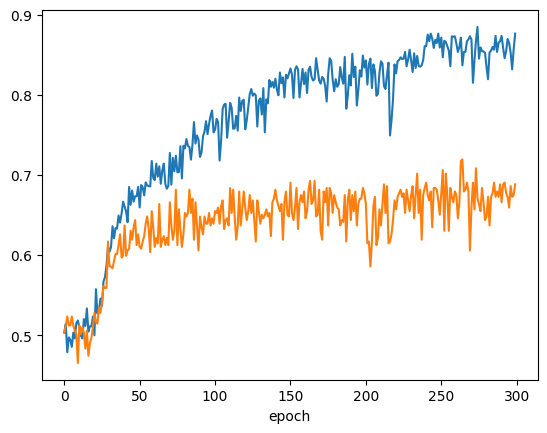

In [ ]:
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

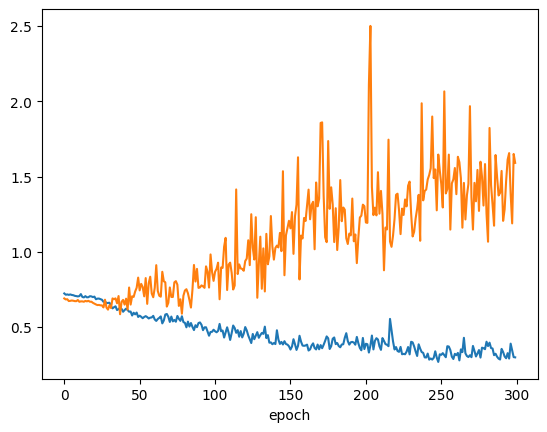

In [ ]:
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.xlabel('epoch')

In [ ]:
best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # Remove the incorrect line attempting to use torch.max on labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Compare predicted directly to labels
    
    test_accuracy = correct / total

print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.6882
